# Cosyne 2018: Synaptic Computation in the NEF

## Abstract

Non-linear interaction in the dendritic tree is known to be an important computational resource in biological neurons. Yet, high-level neural compilers ‒ such as the Neural Engineering Framework (NEF) ‒ neither include non-linear synaptic interaction in their models, nor exploit these interactions systematically. In this study, we extend the NEF towards synaptic computation of non-linear multivariate functions, such as controlled shunting, multiplication, maximum, and the Euclidean norm. We present a theoretical framework that provides sufficient conditions under which non-linear synaptic interaction yields a similar precision compared to traditional NEF methods, while reducing the number of layers, neurons, and latency in the network. The proposed method lends itself to increasing the computational power of neuromorphic hardware systems and improves the NEF's biological plausibility by mitigating one of its long-standing limitations, namely its reliance on linear, current-based synapses. We perform a series of numerical experiments with a conductance-based two-compartment LIF neuron model. Preliminary results show that non-linear interaction of conductance-based synapses is sufficient to compute a wide variety of non-linear functions with performance competitive to using an additional layer of neurons as a non-linearity.

## Setup

The following code imports all the required Python packages. External packages specific to a few functions will be loaded further down in the code.

**Note:** Add a `#` to the line `%%script false` if you want to execute the corresponding code block.

**Note:** As stated below, you must install the `nef_synaptic_computation` package included with this notebook.

In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys, os
os.makedirs('out', exist_ok=True)
os.makedirs('results', exist_ok=True)

from datetime import datetime
import json
import pickle
import multiprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# Import Nengo for reference spiking simulations
import nengo
nengo.rc.set('decoder_cache', 'enabled', 'False')

# Install the nef_synaptic_computation package by executing
# > pip install --user -e .
# from the root directory of the repository. Please install
# the GNU C++ compiler (g++) to get a significant speedup in
# neuron simulations (tested on Linux, might work on OSX)
from nef_synaptic_computation import two_compartment_lif, lif_utils

# Set some matplotlib parameters; esp. match the font to the one used on the poster
plt.rcParams['font.family'] = 'CMU Bright';
plt.rcParams['mathtext.default'] = 'regular';

## Neuron Response Curve from Empirical Simulation

The following code implements empirical simulation of a single spiking neuron. This simulation is used to extract the neuron response curve, i.e. the average activity of the neuron for a sweep over the excitatory and inhibitory input conductances. This response curve is then fitted to a model of the response curve, and the code below will only use these model parameters.

**Note:** The way the code is currently setup, the actual neuron simulation will not be executed, but model parameters that were derived from earlier runs are used (because the following code may take some time to run).

In [2]:
# Neuron and synapse parameters
params = two_compartment_lif.Params()
tau_ref = params.tau_ref  # 2e-3
tau_rc = params.cmSom / params.gLSom # 20e-3
tau_syn_e = 5e-3
tau_syn_i = 10e-3

In [3]:
# Input rates, convert to average conductances gEs and gIs
gEs = np.linspace(0, 100e-6, 50)
gIs = np.linspace(0, 100e-6, 50)

In [4]:
def two_comp_lif_cond_exp_sweep(T=1.0, dt=1e-5):
    def mknoise():
        return two_compartment_lif.make_noise(tau=5e-3, rate=1e2, T=T, dt=dt)

    mgEs, mgIs = np.meshgrid(gEs, gIs)
    it = np.nditer(
            [mgEs, mgIs, None, None],
            [],
            [['readonly'], ['readonly'], ['writeonly', 'allocate'], ['writeonly', 'allocate']])

    ts = np.arange(0, T, dt)
    i = 0
    for (gE, gI, rate, iSyn) in it:        
        spikes, iSyns, _ = two_compartment_lif.simulate(
            gE * mknoise(),
            gI * mknoise(),
            T=T, dt=dt, params=params, record_iSyn=True)
        rate[...] = lif_utils.spike_frequency(ts[spikes > 0])
        iSyn[...] = np.nanmean(iSyns)

        i += 1
        sys.stdout.write("\r{:6.2f}% done".format(i * 100 / mgEs.size))
        sys.stdout.flush()
        
    output_rates = it.operands[2]
    output_currents = it.operands[3]
    return output_rates, output_currents

In [5]:
%%script false

# Executing this code will take some time
# (especially when the C++ simulator is not available)
output_rates, output_currents = two_comp_lif_cond_exp_sweep();

In [6]:
%%script false

def plot_contour(xs, ys, zs, mask, levels=None):
    fig, ax = plt.subplots()
    zs = np.copy(zs)
    zs[~mask] = np.nan
    contour = ax.contourf(xs, ys, zs, 10 if levels is None else levels, cmap='viridis')
    levels = contour.levels if levels is None else levels
    ax.contour(xs, ys, zs, levels, colors=["w"], linestyles=[(0, (1, 3))])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(contour, cax=cax, orientation='vertical');
    return ax, levels

mask = output_rates > 1
j_empirical = two_compartment_lif.from_biological_current(output_currents, params)
ax, levels = plot_contour(gEs * 1e6, gIs * 1e6, j_empirical, mask)
ax.set_xlabel('Excitatory conductance [µS]')
ax.set_ylabel('Inhibitory conductance [µS]')
ax.set_title('Empirical Average Somatic Currents');

j_from_rate = lif_utils.lif_rate_inv(output_rates)
ax, levels = plot_contour(gEs * 1e6, gIs * 1e6, j_from_rate, mask, levels)
ax.set_xlabel('Excitatory conductance [µS]')
ax.set_ylabel('Inhibitory conductance [µS]')
ax.set_title('Reconstructed Somatic Currents');

print("RMSE between empirical and reconstructed currents: {:.4f}".format(
    np.sqrt(np.mean(
        (j_empirical[mask] -
         j_from_rate[mask])**2)))) 

## Fitting the Neuron Response Curve to a Rational Function

Assuming a constant membrane potential in the second (somatic) compartment of the LIF neuron, the current $J$ flowing into the soma can be expressed as a rational function
$$\begin{align}
J = \frac{a_0 + a_1 g_\mathrm{E} + a_2 \mathrm{g_I}}{b_0 + b_1 g_\mathrm{E} + b_2 \mathrm{g_I}}
\end{align}$$

In [7]:
j_model_fun = lambda w, gE, gI: (w[0] + w[1] * gE + w[2] * gI) / (w[3] + w[4] * gE + w[5] * gI)
j_model_fun_cur = lambda gE, gI: gE - gI

In [8]:
%%script false

# Estimates the x-intercept given the target currents and the input conductances
def estimate_x_intercept(Jtar, gE, gI):
    # Find the gE corresponding to each gI at which the target current is just larger than one
    gE_values = np.unique(gE)
    pnts = []
    for gE_value in gE_values:
        mask = gE == gE_value
        if np.any(Jtar[mask] > 1):
            i0 = np.argmax(gI[mask][Jtar[mask] > 1])
            i1 = np.argmax(gI[mask] > gI[mask][i0])
            if i0 > i1:
                continue
            g0, J0 = gI[mask][i0], Jtar[mask][i0]
            g1, J1 = gI[mask][i1], Jtar[mask][i1]
            m = (g0 - g1) / (J0 - J1)
            b = g0 - J0 * m
            pnts.append((gE_value, m + b))

    # Fit a straight line through the gE, gI pairs computed above
    pnts = np.array(pnts).T
    coeffs = np.polyfit(pnts[0], pnts[1], 1)
    return coeffs

# Detailed current model -- better suited for optimisation since the weights are in a
# much saner range
def current_model(w, gE, gI):
    vs = (params.v_thresh + params.EL) * 0.5
    b = (params.EE * gE + w[0] * params.EI * gI + (params.EL * params.gLDen + vs * params.gC) * w[1])
    A = (w[2] * gE + w[3] * gI + (params.gLDen + params.gC) * w[4])
    J = (b / A - vs) * params.gC
    return two_compartment_lif.from_biological_current(J)

# Converts the weights for current_model to parameters for j_model_fun
def cvt_current_model_weights(w):
    vs = (params.v_thresh + params.EL) * 0.5
    scale = two_compartment_lif.from_biological_current(1)
    a0 = params.gC * (vs * (w[1] - w[4]) * params.gC - params.gLDen * (w[4] * vs - params.EL * w[1])) * scale
    a1 = -params.gC * (w[2] * vs - params.EE) * scale
    a2 = -params.gC * (w[3] * vs - w[0] * params.EI) * scale
    b0 = w[4] * (params.gC + params.gLDen)
    b1 = w[2]
    b2 = w[3]
    return np.array((a0, a1, a2, b0, b1, b2)) / a1

def fit_current_model(Jtar, gE, gI, xi=None, xi_weight=0.25):
    import scipy.optimize

    # Only fit the model where we have a non-zero significant output rate
    valid = Jtar > 1

    # Fetch the unique gE values
    gEs = np.unique(gE)

    # Target error function -- minimise L2 error between target
    # and model
    err = lambda w: \
        np.sqrt(np.mean(((current_model(w, gE[valid], gI[valid]) - Jtar[valid]) ** 2))) + \
        xi_weight * (0 if xi is None else np.sqrt(np.mean((current_model(w, gEs, xi[0] * gEs + xi[1]) - 1) ** 2)))

    # Fit model parameters
    w0 = np.ones(5) # Initialise with some reasonable parameters
    res = scipy.optimize.basinhopping(err, w0)
    w = cvt_current_model_weights(res.x)
    print("Weights:\n", w)
    print("Error:\n", res.fun)
    return w

# Fetch the gEs, gIs, and corresponding target values we
# want to fit the model to
mgEs, mgIs = np.meshgrid(gEs, gIs)
xi = estimate_x_intercept(j_from_rate, mgEs, mgIs)
w = fit_current_model(j_from_rate, mgEs, mgIs, xi)

In [9]:
%%script false

j_model = j_model_fun(w, mgEs.flatten(), mgIs.flatten()).reshape(mgEs.shape)
fig, ax = plt.subplots()
contour = ax.contourf(gEs * 1e6, gIs * 1e6, j_model.reshape(mgEs.shape), levels, cmap='viridis')
ax.contour(gEs * 1e6, gIs * 1e6, j_from_rate, levels, linestyles=('--'), colors=('white'))
ax.set_xlabel('Excitatory conductance [$\mathrm{\mu S}$]')
ax.set_ylabel('Inhibitory conductance [$\mathrm{\mu S}$]')
ax.set_title('Somatic Current Fit (colour) vs. to Emprical (dashed)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(contour, cax=cax, orientation='vertical');

In [10]:
#%%script false

# Result of all the above calculations
w = np.array((
    -2.30936969e-07,
     1.00000000e+00,
    -3.42536475e-01,
    -1.54003411e-08,
     9.86123522e-02,
     7.61565175e-02))

## Network setup

We manually generate standard parameters for a network of LIF neurons with three populations à 100 neurons each. The first two populations project onto the third population, but instead of computing the sum of the values represented by the first two populations we'd like to compute the product of the two values. In particular, we're only concerned about positive input values, that is the product as operator $\cdot : [0, 1] \times [0, 1] \longrightarrow [0, 1]$.

The following code computes a set of parameters, tuning curves, and decoders for each population.

In [11]:
def generate_tuning_curves(N=100, max_rate=200, n=3):
    max_rates = np.random.uniform(max_rate / 2, max_rate, (n, N))
    intercepts = np.random.uniform(-0.95, 0.95, (n, N))
    encoders = np.random.choice([-1, 1], (n, N))
    neuron = nengo.LIF(tau_rc=tau_rc, tau_ref=tau_ref)
    gain, bias = neuron.gain_bias(max_rates, intercepts)

    # Calculate population tuning curves and decoders
    res = 100
    xs = np.linspace(-1, 1, res)
    As = np.zeros((n, res, N))
    decoders = np.zeros((n, N))
    for ni in range(n):
        for Ni in range(N):
            As[ni, :, Ni] = lif_utils.lif_rate(
                (xs * encoders[ni, Ni] * gain[ni, Ni] + bias[ni, Ni]))
            decoders[ni] = nengo.solvers.LstsqL2()(As[ni], xs)[0]

    return n, xs, As, gain, bias, encoders, decoders, neuron

In [12]:
def assign_neuron_types(N=200, pinh=0.3):
    """
    Assigns a neuron type to each neuron
    """
    inhibitory = np.random.uniform(0, 1, N) < pinh
    return np.array((~inhibitory, inhibitory), dtype=np.bool)

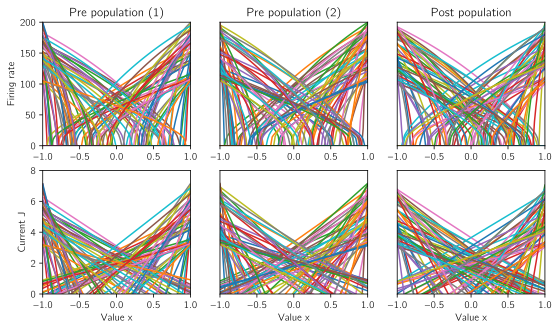

In [13]:
#%%script false

# Plot some tuning curves as an example of what they look like
n, xs, As, gain, bias, encoders, decoders, _ = generate_tuning_curves()
neuron_types = assign_neuron_types()
fig, axs = plt.subplots(2, 3, figsize=(9, 5))
for ni in range(n):
    axs[0, ni].plot(xs, As[ni])
    if ni < 2:
        axs[0, ni].set_title("Pre population ({:d})".format(ni + 1))
    else:
        axs[0, ni].set_title("Post population")
    axs[0, ni].set_ylabel("Firing rate");
    axs[0, ni].set_xlim(-1, 1)
    axs[0, ni].set_ylim(0, 200)
    axs[0, ni].get_yaxis().set_visible(ni == 0)

# Plot the currents associated with each population
for ni in range(n):
    axs[1, ni].plot(xs, gain[ni] * (xs[:, None] @ encoders[ni, None]) + bias[ni])
    axs[1, ni].set_xlabel("Value $x$")
    axs[1, ni].set_ylabel("Current J");
    axs[1, ni].set_xlim(-1, 1)
    axs[1, ni].set_ylim(0, 8)
    axs[1, ni].get_yaxis().set_visible(ni == 0)

## Generating “Training” Data

In order to train the network, let's first generate some reference data. To this end I uniformly sample the 2D-input space and compute the desired target function (here: $h(x, y) = xy$).

In [14]:
def generate_training_data(h=lambda x, y: x * y, res=21):
    # Generate sample points on a uniform grid
    xs = np.linspace(0, 1, res)
    data_in_x, data_in_y = np.meshgrid(xs, xs)
    data_in = np.array((data_in_x.flatten(), data_in_y.flatten()))

    # Generate the target data
    data_tar = h(data_in[0], data_in[1])

    return data_in, data_tar

def target_currents(data_tar, gain, bias, encoders):
    return data_tar[:, None] @ (gain * encoders)[None, :] + bias[None, :]

def population_activities(data_in, data_tar, gain, bias, encoders):
    assert gain.shape == bias.shape
    assert gain.shape[0] == encoders.shape[0]

    n = 3
    N = gain.shape[1]
    n_samples = data_in.shape[1]

    neuron = nengo.LIF(tau_rc=tau_rc, tau_ref=tau_ref)
    A = np.empty((n, N, n_samples))
    for Ni in range(N):
        A[0, Ni] = neuron.rates(data_in[0] * encoders[0, Ni], gain[0, Ni], bias[0, Ni])
        A[1, Ni] = neuron.rates(data_in[1] * encoders[1, Ni], gain[1, Ni], bias[1, Ni])
        A[2, Ni] = neuron.rates(data_tar * encoders[2, Ni], gain[2, Ni], bias[2, Ni])
    Apre = (A[0:2].reshape((2*N, n_samples))).T
    Apost = (A[2]).T
    return Apre, Apost

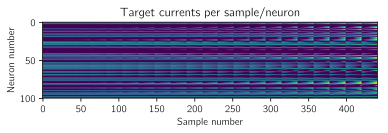

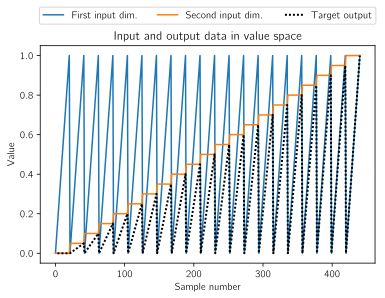

In [15]:
#%%script false

# Plot the training data and population activities for some function h
#h = lambda x, y: 0.5 * (x + y)
h = lambda x, y: x * y

data_in, data_tar = generate_training_data(h)
Jpost = target_currents(data_tar, gain[2], bias[2], encoders[2])

fig, ax = plt.subplots()
ax.imshow(Jpost.T, vmin=0)
ax.set_title('Target currents per sample/neuron')
ax.set_xlabel("Sample number")
ax.set_ylabel("Neuron number")

fig, ax = plt.subplots()
ax.plot(data_in[0], label="First input dim.")
ax.plot(data_in[1], label="Second input dim.")
ax.plot(data_tar, linewidth=2, color='k', linestyle=(1, (1, 1)), label="Target output")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3)
ax.set_xlabel("Sample number")
ax.set_ylabel("Value")
ax.set_title("Input and output data in value space");

## Solve for Weight Matrices

The following code optimally solves for excitatory/inhibitory weights using non-negative least squares. Essentially, the problem that must be solved is the following (where $\circ$ is the element wise matrix product, or Hadamard product):
$$\begin{align}
J &= \frac{a_0 + a_1 g_\mathrm{E} + a_2 g_\mathrm{I}}{b_0 + b_1 g_\mathrm{E} + b_2 g_\mathrm{I}} \\
  &= \frac{a_0 + a_1 A \cdot w_\mathrm{E} + a_2 A \cdot w_\mathrm{I}}{b_0 + b_1 A \cdot w_\mathrm{E} + b_2 A \cdot w_\mathrm{I}} \\
\Leftrightarrow 
0 &= (b_0 J - a_0) + (b_1 J - a_1) \circ A \cdot w_\mathrm{E} + (b_2 J - a_2) \circ A \cdot  w_\mathrm{I} \\
  &= J_0 + J_1 \cdot w_\mathrm{E} + J_2 \cdot w_\mathrm{I} \\
\Leftrightarrow
-J_0 &= \begin{pmatrix} J_1  & J_2 \end{pmatrix} \cdot \begin{pmatrix} w_\mathrm{E} \\ w_\mathrm{I}\end{pmatrix}
\end{align}$$
where $w_\mathrm{E} \geq 0$, $w_\mathrm{I} \geq 0$. Note that the possible target currents are bounded by $(a_2 / b_2, a_1 / b_1)$.

One problem with this approach is that we're needlessly optimising for negative target currents. Negative currents ‒ or generally speaking, any current $J \leq 1$ ‒ will always result in a zero output rate. Since in the end we are interested in the neuron output rates, the magnitude of the current that produces the zero output rate does not matter. We can thus split the above equation into two parts. One equality constraint for the positive target currents $J > 1$, and an inequality constraint for the negative target currents.

The equation for the positive currents is given as
$$\begin{align}
J^+ &= \frac{a_0 + a_1 g^+_\mathrm{E} + a_2 g^+_\mathrm{I}}{b_0 + b_1 g^+_\mathrm{E} + b_2 g^+_\mathrm{I}} \\
  &= \frac{a_0 + a_1 A^+ \cdot w_\mathrm{E} + a_2 A^+ \cdot w_\mathrm{I}}{b_0 + b_1 A^+ \cdot w_\mathrm{E} + b_2 A^+ \cdot w_\mathrm{I}} \,,
\end{align}$$
where $A^+$ and $J^+$ are partial matrices containing only the samples where $J > 1$.

Likewise, the following constraint must hold when restricting $A$ to the samples with negative target current ($J \leq 1$) $A^-$:
$$\begin{align}
1 &\geq \frac{a_0 + a_1 g_\mathrm{E} + a_2 g_\mathrm{I}}{b_0 + b_1 g_\mathrm{E} + b_2 g_\mathrm{I}} \\
  &= \frac{a_0 + a_1 A^- \cdot w_\mathrm{E} + a_2 A^- \cdot w_\mathrm{I}}{b_0 + b_1 A^- \cdot w_\mathrm{E} + b_2 A^- \cdot w_\mathrm{I}} \,,
\end{align}$$
while at the same time $w_E \geq 0$, $w_I \geq 0$.

As before we can rearrange these equations
$$\begin{align}
0 &= (b_0 J^+ - a_0) + (b_1 J^+ - a_1) \circ A^+ \cdot w_\mathrm{E} + (b_2 J^+ - a_2) \circ A^+ \cdot  w_\mathrm{I} \\
  &= J^+_0 + J^+_1 \cdot w_\mathrm{E} + J^+_2 \cdot w_\mathrm{I} \\
\Leftrightarrow J^+_0 &= \begin{pmatrix} J^+_1 & J^+_2 \end{pmatrix} \cdot \begin{pmatrix} w_\mathrm{E} \\ w_\mathrm{I}\end{pmatrix}
\end{align}$$
and since $b_0, b_1, b_2 \geq 0$ the inequality becomes
$$\begin{align}
b_0 + b_1 A^- \cdot w_\mathrm{E} + b_2 A^- \cdot w_\mathrm{I} &\geq a_0 + a_1 A^- \cdot w_\mathrm{E} + a_2 A^- \cdot w_\mathrm{I} \\
\Leftrightarrow b_0-a_0 &\geq \begin{pmatrix} (a_1 - b1) A^- & (a_2 - b_2) A^- \end{pmatrix} \cdot \begin{pmatrix} w_\mathrm{E} \\ w_\mathrm{I}\end{pmatrix}
\end{align}$$
We can reformulate these equations as a convex quadratic programing problem
$$\begin{align}
\text{minimize } & \frac{1}2 \big(x^T G x + a^T x\big) \\
\text{w.r.t. } &C x \leq b
\end{align}$$
where $G = \begin{pmatrix} J^+_1 & J^+_2 \end{pmatrix}^T \begin{pmatrix} J^+_1 & J^+_2 \end{pmatrix}$ and $a = -\begin{pmatrix} J^+_1 & J^+_2 \end{pmatrix}^T \cdot J^+_0$, as well as $C = \begin{pmatrix} -1 & (a_1 - b_1) A^+ & (a_2 - b_2) A^- \end{pmatrix}$ and $b = \begin{pmatrix} 0 & b_0-a_0 \end{pmatrix}$.

In [16]:
def solve_conductance_weight_matrices_quadprog(Apre, Jpost, w, neuron_types=None, reg=1e-3):
    from cvxopt import matrix, solvers
    solvers.options['show_progress'] = False

    # Fetch the model weights
    a0, a1, a2, b0, b1, b2 = w

    assert Apre.shape[0] == Jpost.shape[0]
    m = Apre.shape[0]
    Npre = Apre.shape[1]
    Npost = Jpost.shape[1]
    WE, WI = np.zeros((2, Npre, Npost))
    sigma = reg * np.max(Apre)

    # If the neurons are not explicitly assigned types, assume
    # that all pre-neurons may be both excitatory and inhibitory
    if neuron_types is None:
        neuron_types = np.ones((2, Npre), dtype=np.bool)
    exc, inh = neuron_types

    # Count each use of a neuron as exciatory/inhibitory
    # individually
    Npre_exc = np.sum(exc)
    Npre_inh = np.sum(inh)
    Npre_tot = Npre_exc + Npre_inh

    # Clip Jpost to the valid range
    if np.abs(b2) > 0 and np.abs(b1) > 0:
        Jpost = Jpost.clip(0.975 * a2 / b2, 0.975 * a1 / b1)

    # Iterate over each post neuron individually and solve for weights
    for i_post in range(Npost):
        # Select samples with positive and negative target currents
        m_pos = Jpost[:, i_post] > 1
        m_neg = Jpost[:, i_post] <= 1

        # Limit the input matrix and the target vector to the positive
        # currents
        Apre_pos = Apre[m_pos]
        Apre_neg = Apre[m_neg]
        J_pos = Jpost[m_pos, i_post]

        # Split the pre activities into neurons marked as excitatory,
        # as well as neurons marked as inhibitory
        Apre_pos_exc, Apre_pos_inh = Apre_pos[:, exc], Apre_pos[:, inh]
        Apre_neg_exc, Apre_neg_inh = Apre_neg[:, exc], Apre_neg[:, inh]
        
        J0 = J_pos * b0 - a0
        J1 = np.diag(a1 - J_pos * b1) @ Apre_pos_exc
        J2 = np.diag(a2 - J_pos * b2) @ Apre_pos_inh

        # Form the matrices G and a
        JJ = np.concatenate((J1, J2), axis=1)
        G, a = JJ.T @ JJ, -JJ.T @ J0
        Gold = np.copy(G)
        G += np.eye(G.shape[0]) * m * sigma ** 2

        # Form the matrices C and b
        C = np.concatenate((-np.eye(Npre_tot),
                            np.concatenate(((a1 - b1) * Apre_neg_exc, (a2 - b2) * Apre_neg_inh), axis=1)),
                           axis=0)
        b = np.concatenate((np.zeros(Npre_tot), (b0 - a0) * np.ones(np.sum(m_neg))), axis=0)

        # Solve the quadratic programming problem
        x = np.array(solvers.qp(matrix(G), matrix(a), matrix(C), matrix(b))['x'])[:, 0]

        WE[exc, i_post] = x[:Npre_exc]
        WI[inh, i_post] = x[Npre_exc:]
    return WE, WI
    
def solve_current_weight_matrices_quadprog(Apre, Jpost, neuron_types=None, reg=1e-3):
    return solve_conductance_weight_matrices_quadprog(Apre, Jpost, (0, 1, -1, 1, 0, 0), neuron_types, reg)

In [17]:
#%%script false

# Solve for the weight matrices WE, WI
Apre, Apost = population_activities(data_in, data_tar, gain, bias, encoders)
WE, WI = solve_conductance_weight_matrices_quadprog(Apre, Jpost, w, neuron_types, reg=0.1e-2)
WE_cur, WI_cur = solve_current_weight_matrices_quadprog(Apre, Jpost, neuron_types, reg=1e-2)

### Visualisation/Analysis

The following cells produce various visualisations of the computed weight matrices and the corresponding decoded functions.

In [18]:
#%%script false

N_pre, N_post = WE.shape
Jpost_opt = j_model_fun(w, Apre @ WE, Apre @ WI)
Apost_opt = lif_utils.lif_rate(Jpost_opt)
Jpost_opt_cur = j_model_fun_cur(Apre @ WE_cur, Apre @ WI_cur)
Apost_opt_cur = lif_utils.lif_rate(Jpost_opt_cur)

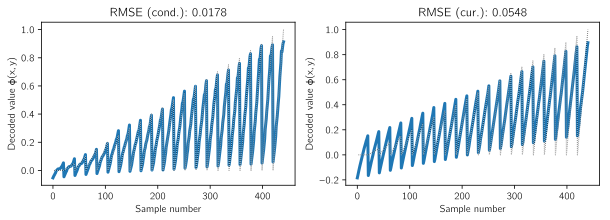

In [19]:
#%%script false

# Compares the decoded funtion to the target function
def plot_decoded(Apost, ax, title):
    ax.plot(Apost @ decoders[2], linewidth=3.0, label="Decoded")
    ax.plot(data_tar, 'k', linewidth=1.0, linestyle=(1, (1, 1)), label="Target", alpha=0.5)
    ax.plot(data_tar, 'w', linewidth=1.0, linestyle=(0, (1, 1)), alpha=0.5)
    ax.set_xlabel('Sample number')
    ax.set_ylabel('Decoded value $\\phi(x, y)$')
    rmse = np.sqrt(np.mean((Apost @ decoders[2] - data_tar)**2))
    ax.set_title('RMSE (' + title + '): {:0.4f}'.format(rmse));

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plot_decoded(Apost_opt, axs[0], 'cond.')
plot_decoded(Apost_opt_cur, axs[1], 'cur.')

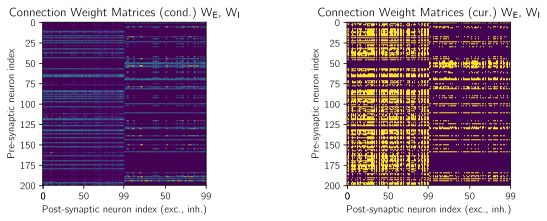

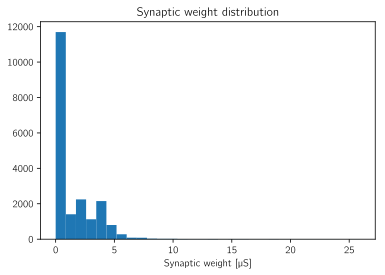

In [20]:
#%%script false

# Analyses the synaptic weight distributions

def plot_weight_matrices(WE, WI, ax, title):
    ax.imshow(np.concatenate((WE, WI), axis=1), vmin=0, vmax=1e-5);
    ax.set_xticks([0, N_post // 2, N_post - 1, 0, 3 * N_post // 2, N_post * 2])
    ax.set_xticklabels([str(0), str(N_post // 2), str(N_post - 1)] * 2)
    ax.set_title("Connection Weight Matrices (" + title + ") $W_\mathrm{E}$, $W_\mathrm{I}$")
    ax.set_xlabel("Post-synaptic neuron index (exc., inh.)");
    ax.set_ylabel("Pre-synaptic neuron index");

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plot_weight_matrices(WE, WI, axs[0], "cond.")
plot_weight_matrices(WE_cur, WI_cur, axs[1], "cur.")

fig, ax = plt.subplots()
ax.hist(np.concatenate((WE[WE > 0].flatten(), WI[WI > 0].flatten())) * 1e6, bins=30);
ax.set_xlabel("Synaptic weight [µS]");
ax.set_title("Synaptic weight distribution");

In [21]:
%%script false

# Visualises the individual decoded currents, as well as the target current

ni = 15 # Which post-neurons to inspect

fig, ax = plt.subplots()
ax.plot(Jpost_opt_cur[:, ni], linewidth=3.0, label="Decoded")
ax.plot(Jpost[:, ni], 'k', linewidth=1.0, linestyle=(1, (1, 1)), label="Target", alpha=0.5)
ax.plot(Jpost[:, ni], 'w', linewidth=1.0, linestyle=(0, (1, 1)), alpha=0.5)
ax.set_title('Target current vs. decoded current')
ax.set_xlabel('Sample number')
ax.set_ylabel('Current $J$')
ax.set_ylim(-3.5, 11);

In [22]:
%%script false

# Visualises the decoded conducate functions and their additive
# superposition in a 3D-plot

ni = 11 # Which post-neuron to inspect

def plot_decoded_conductance_functions():
    # Evaluate the neurons on a rather dense grid
    resolution = 51
    data_in, data_tar = generate_training_data(h, res=resolution)
    Apre, _ = population_activities(data_in, data_tar, gain, bias, encoders)
    gE_dec = Apre @ WE[:, ni]
    gI_dec = Apre @ WI[:, ni]

    # Fetch (gE(x, 0), gI(x, 0)) x and (gE(0, y), gI(0, y))
    x_fun = np.concatenate((
        (gE_dec[0:resolution] - gE_dec[0]).reshape(-1, 1),
        (gI_dec[0:resolution] - gI_dec[0]).reshape(-1, 1)), axis=1)
    y_fun = np.concatenate((
        gE_dec[0::resolution].reshape(-1, 1),
        gI_dec[0::resolution].reshape(-1, 1)), axis=1)

    # Fetch the plot range
    gE_min, gE_max = np.min(gE_dec), np.max(gE_dec)
    gI_min, gI_max = np.min(gI_dec), np.max(gI_dec)
    gE_range = gE_max - gE_min
    gI_range = gI_max - gI_min

    # Plot the decodec value represented by the neuron in the background
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, 225)

    gEs = np.linspace(gE_min - gE_range * 0.1,
                      gE_max + gE_range * 0.1, 200)
    gIs = np.linspace(gI_min - gI_range * 0.1,
                      gI_max + gI_range * 0.1, 200)

    mgEs, mgIs = np.meshgrid(gEs, gIs)
    J = j_model_fun(w, mgEs.flatten(), mgIs.flatten()).reshape(mgEs.shape)
    X = (J - bias[2, ni]) / (gain[2, ni] * encoders[2, ni])

    levels = np.linspace(0, 1, 11) * 1e-9
    contour = ax.contourf(gEs * 1e6, gIs * 1e6,
                         X.reshape(mgEs.shape) * 1e-9,
                         levels, cmap='viridis')
    for poly in contour.collections:
        poly.set_zorder(-1)

    pnts = list(map(int, np.linspace(0, resolution - 1, 3)))
    xs = data_in[0, 0:resolution]
    for pnt in pnts:
        ax.plot((x_fun[:, 0] + y_fun[pnt, 0]) * 1e6,
                (x_fun[:, 1] + y_fun[pnt, 1]) * 1e6,
                zs=np.zeros_like(xs), zorder=1,
                color='grey', linewidth=0.5, linestyle=(0, (1, 1)))
        ax.plot((x_fun[pnt, 0] + y_fun[:, 0]) * 1e6,
                (x_fun[pnt, 1] + y_fun[:, 1]) * 1e6,
                zs=np.zeros_like(xs), zorder=1,
                color='grey', linewidth=0.5, linestyle=(0, (1, 1)))

        ax.plot((x_fun[:, 0] + y_fun[pnt, 0]) * 1e6,
                (x_fun[:, 1] + y_fun[pnt, 1]) * 1e6,
                zs=xs, zorder=2,
                color='white', linewidth=3)
        ax.plot((x_fun[pnt, 0] + y_fun[:, 0]) * 1e6,
                (x_fun[pnt, 1] + y_fun[:, 1]) * 1e6,
                zs=np.ones_like(xs) * xs[pnt],
                zorder=2, color='white', linewidth=3)
        ax.plot((x_fun[:, 0] + y_fun[pnt, 0]) * 1e6,
                (x_fun[:, 1] + y_fun[pnt, 1]) * 1e6,
                zs=xs, zorder=2,
                color='k', linewidth=2, linestyle=(0, (1, 1)))
        ax.plot((x_fun[pnt, 0] + y_fun[:, 0]) * 1e6,
                (x_fun[pnt, 1] + y_fun[:, 1]) * 1e6,
                zs=np.ones_like(xs) * xs[pnt],
                zorder=2, color='k', linewidth=2, linestyle=(0, (1, 1)))
        ax.plot((x_fun[:, 0] + y_fun[pnt, 0]) * 1e6,
                (x_fun[:, 1] + y_fun[pnt, 1]) * 1e6,
                zs=xs, zorder=2, color='grey', linewidth=0.5, linestyle=(0, (1, 1)))


    for i in pnts:
        for j in pnts:
            x, y, z = (
                (x_fun[i, 0] + y_fun[j, 0]) * 1e6,
                (x_fun[i, 1] + y_fun[j, 1]) * 1e6,
                xs[i]);
            ax.plot([x, x], [y, y], [z, 0], linewidth=0.5, linestyle=(0, (1, 1)), color='grey')
            ax.plot([x], [y], [0], color='grey', zorder=1, marker='o', markersize=4)
            ax.plot([x], [y], [z], color='white', marker='o', markersize=7)
            ax.plot([x], [y], [z], color='k', marker='o', markersize=4)
            ax.plot([x], [y], [z], color='k', marker='o', markersize=4)
            ax.text(x, y, z,
                    '(${:3.1f}, {:3.1f}$)'.format(
                        data_in[0, i],
                        data_in[0, j]))

    ax.set_xlabel("Excitatory conductance [µS]")
    ax.set_ylabel("Inhibitory conductance [µS]")
    ax.set_zlabel("Input $x$")
    ax.set_zlim(0, 1)
    ax.set_xlim(np.min(gEs) * 1e6, np.max(gEs) * 1e6)
    ax.set_ylim(np.min(gIs) * 1e6, np.max(gIs) * 1e6)

plot_decoded_conductance_functions()

## Spiking Simulation

The following code implements a time-dynamic spiking neuron simulation of the above network.

In [23]:
def calculate_input_spike_trains(T, dt, xs, gain, bias, encoders, rate=False, intermediate=False):
    """
    This function simulatea two independent populations of LIF neurons
    representing the values "xs" and returns the corresponding spike
    trains.
    """
    N = gain.shape[1]
    if rate:
        neuron = nengo.LIFRate(tau_rc=tau_rc, tau_ref=tau_ref)
    else:
        neuron = nengo.LIF(tau_rc=tau_rc, tau_ref=tau_ref)
    net = nengo.Network()
    with net:
        node_in = nengo.Node(lambda t: xs[min(len(xs) - 1, int(t / dt))])

        ens_X = nengo.Ensemble(
            N, 1, encoders=encoders[0].reshape(-1, 1),
            gain=gain[0], bias=bias[0], neuron_type=neuron)
        ens_Y = nengo.Ensemble(
            N, 1, encoders=encoders[1].reshape(-1, 1),
            gain=gain[1], bias=bias[1], neuron_type=neuron)

        probe_X = nengo.Probe(ens_X.neurons)
        probe_Y = nengo.Probe(ens_Y.neurons)
        nengo.Connection(node_in[0], ens_X, synapse=None)
        nengo.Connection(node_in[1], ens_Y, synapse=None)
        
        if intermediate:
            ens_inter = nengo.Ensemble(
                N, 2, encoders=encoders[3],
                gain=gain[3], bias=bias[3], neuron_type=neuron,
                radius=np.sqrt(2))
            probe_inter = nengo.Probe(ens_inter.neurons)
            nengo.Connection(ens_X, ens_inter[0])
            nengo.Connection(ens_Y, ens_inter[1])

    with nengo.Simulator(net, dt=dt) as sim:
        sim.run(T)

    if not intermediate:
        return sim.data[probe_X], sim.data[probe_Y]
    else:
        return sim.data[probe_inter]

In [24]:
def run_single_spiking_trial(
            h=lambda x, y: 0.5 * (x + y),
            reg=None,
            dt=1e-4,
            T=10.0,
            setup="no_intermediate_conductance"):

    if not setup in ("no_intermediate_conductance", "no_intermediate_current", "intermediate_current"):
        raise Exception("Wrong setup string")

    # Automatically set the regularisation term according to the setup
    if reg is None:
        if setup == "no_intermediate_conductance":
            reg = 5e-3
        elif setup == "no_intermediate_current":
            reg = 1e-2
        elif setup == "intermediate_current":
            reg = 1e-2
    
    # Generate a random set of tuning curves
    print("Generating tuning curves and training data...")
    n = 4 if setup == "intermediate_current" else 3
    _, xs, As, gain, bias, encoders, decoders, neuron = generate_tuning_curves(n=n)

    # Assign the neuron types for the pre-population
    N_pre = 100 if setup == "intermediate_current" else 200
    neuron_types = assign_neuron_types(N_pre)

    # Replace the encoders with two-dimensional encoders for the intermediate population
    if setup == "intermediate_current":
        encoders = list(encoders)
        encoders[3] = np.random.normal(0, 1, (2, encoders[3].size))
        encoders[3] = (encoders[3] / np.linalg.norm(encoders[3], axis=0)).T

    # Generate some training data for the given function h
    data_in, data_tar = generate_training_data(h)
    Jpost = target_currents(data_tar, gain[2], bias[2], encoders[2])

    # Calculate the pre
    if setup == "intermediate_current":
        N_pre = encoders[3].shape[0]
        Apre = np.empty((data_in.shape[1], N_pre))
        for Ni in range(N_pre):
            Apre[:, Ni] = neuron.rates(encoders[3][Ni] @ data_in / np.sqrt(2), gain[3, Ni], bias[3, Ni])
    else:
        Apre, _ = population_activities(data_in, data_tar, gain, bias, encoders)

    # Solve for the weight matrices WE, WI
    print("Solving weight matrices...")   
    if setup == "no_intermediate_conductance":
        WE, WI = solve_conductance_weight_matrices_quadprog(Apre, Jpost, w, neuron_types, reg=reg)
    elif setup == "no_intermediate_current" or setup == "intermediate_current":
        WE, WI = solve_current_weight_matrices_quadprog(Apre, Jpost, neuron_types, reg=reg)

    # Calculate the input spike trains when sampling the
    # 2D Hilbert Curve
    print("Simulating pre-population...")
    ts = np.arange(0, T, dt)
    xs = nengo.utils.functions.HilbertCurve(4)(ts / T)
    if setup == "intermediate_current":
        spikes_pre = calculate_input_spike_trains(T, dt, xs, gain, bias, encoders, intermediate=True)
    else:
        xs_spikes, ys_spikes = calculate_input_spike_trains(T, dt, xs, gain, bias, encoders)
        spikes_pre = np.concatenate((xs_spikes, ys_spikes), axis=1)

    # Apply the synaptic filter to the pre-synaptic spikes
    spikes_pre_flt_exc = nengo.Lowpass(tau_syn_e).filt(spikes_pre, dt=dt)
    spikes_pre_flt_inh = nengo.Lowpass(tau_syn_i).filt(spikes_pre, dt=dt)

    # Apply the synaptic weights to the filtered input spike trains
    # and feed them into the neuron simulator
    print("Simulating post-population...")
    N_post = WE.shape[1]
    spikes_post = np.zeros((len(ts), N_post))
    if setup == "no_intermediate_conductance":
        for i in range(N_post):
            gEs = spikes_pre_flt_exc @ WE[:, i]
            gIs = spikes_pre_flt_inh @ WI[:, i]
            spikes_post[:, i], _, _ = \
                two_compartment_lif.simulate(gEs, gIs, T=T, dt=dt)
            sys.stdout.write("\r{:6.2f}% done".format((i + 1) * 100 / N_post))
            sys.stdout.flush()
    elif setup == "no_intermediate_current" or setup == "intermediate_current":
        refractory_time, voltage = np.zeros((2, N_post))
        J = spikes_pre_flt_exc @ WE - spikes_pre_flt_inh @ WI
        for j, _ in enumerate(ts):
            neuron.step_math(dt, J[j], spikes_post[j], voltage, refractory_time)
            if j % 1000 == 0 or j == len(ts) - 1:
                sys.stdout.write("\r{:6.2f}% done".format((j + 1) * 100 / len(ts)))
                sys.stdout.flush()
    sys.stdout.write("\n")

    # Return the unfiltered pre- and postpoulation spikes,
    # as well as the optimal decoders
    return ts, xs, spikes_pre, spikes_post, decoders, neuron_types

### Code for finding the optimal regularisation term

Due to different value magnitudes, the regularisation term is not comparable between current and conductance based synapses. The following code sweeps over the regularisation value and performs a single spiking experiment for each.

In [25]:
%%script false

def run_sweep_regularisation_task(e):
    def calc_err(reg, setup):
        dt = 1e-4
        T = 10.0
        h=lambda x, y: 0.5 * (x + y)
        ts, xs, spikes_pre, spikes_post, decoders, _ = \
            run_single_spiking_trial(h=h, dt=dt, T=T, reg=reg, setup=setup)

        N_pre = spikes_pre.shape[1]
        N_post = spikes_post.shape[1]

        xs_dec_flt = nengo.Lowpass(100e-3).filt(spikes_pre[:, :N_pre//2] @ decoders[0])
        ys_dec_flt = nengo.Lowpass(100e-3).filt(spikes_pre[:, N_pre//2:] @ decoders[1])
        post_dec_flt = nengo.Lowpass(100e-3).filt(spikes_post @ decoders[2])
        tar_flt = h(xs_dec_flt, ys_dec_flt)
        return np.sqrt(np.mean((post_dec_flt - tar_flt)**2))

    i, j, reg, k = e
    np.random.seed(48298 * i + 2919 * j)
    if k == 0:
        return calc_err(reg, "no_intermediate_current")
    elif k == 1:
        return calc_err(reg, "no_intermediate_conductance")

def sweep_regularisation(res=50, repeat=20):
    regs = np.logspace(-4, 1, res)
    items = [(i, j, regs[j], k) for i in range(repeat) for j in range(len(regs)) for k in range(2)]
    p = multiprocessing.Pool()
    errs = p.map(run_sweep_regularisation_task, items)
    return np.array(errs).reshape((repeat, len(regs), 2)), regs

errs, regs = sweep_regularisation()
np.save('results/results_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.npy', errs)

In [26]:
#%%script false

# Load an older result to show what this may look like
regs = np.logspace(-4, 1, 50)
errs = np.load('results/results_2018_02_21_22_16_11_mul.npy')

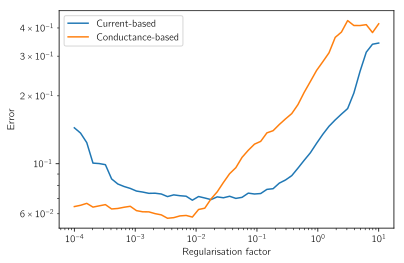

In [27]:
#%%script false
fig, ax = plt.subplots()
ax.loglog(regs, np.mean(errs[:, :, 0], axis=0), label='Current-based')
ax.loglog(regs, np.mean(errs[:, :, 1], axis=0), label='Conductance-based')
ax.set_xlabel('Regularisation factor')
ax.set_ylabel('Error')
ax.legend(loc='best');

**Results:** Weights for conductance-based synapses are best computed with a regularisation term of about $w = 5 \cdot 10^{-3}$, current-based synaptic weights are best computed with a regularisation term of $w = 10^{-2}$.

### Statistics for a single spiking simulation

In [28]:
%%script false

dt = 1e-4
T = 10.0
h=lambda x, y: x * y
repeat = 50

def run_spiking_simulation_task(i):
    ts, xs, spikes_pre, spikes_post, decoders, neuron_types = \
        run_single_spiking_trial(h=h, dt=dt, T=T, setup="no_intermediate_conductance")

    N_pre = spikes_pre.shape[1]
    xs_dec = spikes_pre[:, :N_pre//2] @ decoders[0]
    ys_dec = spikes_pre[:, N_pre//2:] @ decoders[1]
    post_dec = spikes_post @ decoders[2]
    return xs_dec, ys_dec, post_dec, neuron_types

p = multiprocessing.Pool()
res = p.map(run_spiking_simulation_task, list(range(repeat)))
xs_dec, ys_dec, post_dec, neuron_types = zip(*res)

In [29]:
%%script false

# Filters the individual spike traces and extract the percentiles

xs_dec_flt_100, ys_dec_flt_100, post_dec_flt_100, tar_flt_100 = \
    [[None] * repeat for _ in range(4)]
for i in range(repeat):
    xs_dec_flt_100[i] = nengo.Lowpass(100e-3).filt(xs_dec[i], dt=dt)
    ys_dec_flt_100[i] = nengo.Lowpass(100e-3).filt(ys_dec[i], dt=dt)
    post_dec_flt_100[i] = nengo.Lowpass(100e-3).filt(post_dec[i], dt=dt)
    tar_flt_100[i] = h(xs_dec_flt_100[i], ys_dec_flt_100[i])

xs_dec_flt_100_perc_50 = np.percentile(np.array(xs_dec_flt_100), 50.0, axis=0)
ys_dec_flt_100_perc_50 = np.percentile(np.array(ys_dec_flt_100), 50.0, axis=0)

post_dec_flt_100_perc_100 = np.percentile(np.array(post_dec_flt_100), 100.0, axis=0)
post_dec_flt_100_perc_75 = np.percentile(np.array(post_dec_flt_100), 75.0, axis=0)
post_dec_flt_100_perc_50 = np.percentile(np.array(post_dec_flt_100), 50.0, axis=0)
post_dec_flt_100_perc_25 = np.percentile(np.array(post_dec_flt_100), 25.0, axis=0)
post_dec_flt_100_perc_0 = np.percentile(np.array(post_dec_flt_100), 0.0, axis=0)

tar_flt_100_perc_75 = np.percentile(np.array(tar_flt_100), 75.0, axis=0)
tar_flt_100_perc_50 = np.percentile(np.array(tar_flt_100), 50.0, axis=0)
tar_flt_100_perc_25 = np.percentile(np.array(tar_flt_100), 25.0, axis=0)


# Plot the results

ss = 100 # subsampling for plotting
ts = np.arange(0, T, dt)

fig, axs = plt.subplots(3, 1, figsize=(4, 3), gridspec_kw={
        'height_ratios': [8, 1, 1]
})


axs[0].fill_between(
    ts[::ss],
    post_dec_flt_100_perc_0[::ss],
    post_dec_flt_100_perc_100[::ss],
    color='#729fcf', label="Min/max")
axs[0].fill_between(
    ts[::ss],
    post_dec_flt_100_perc_25[::ss],
    post_dec_flt_100_perc_75[::ss],
    color='#3465a4', label="25/75% percentile")
axs[0].plot(ts[::ss], post_dec_flt_100_perc_50[::ss],
    color='#204a87',
    linewidth=1, label="Median")

axs[0].plot(ts[::ss], tar_flt_100_perc_50[::ss],
    color='white',
    linewidth=1)
axs[0].plot(ts[::ss], tar_flt_100_perc_50[::ss],
    color='k',
    linestyle=(0, (1, 1)),
    linewidth=1,
    label="Target value")

axs[0].set_xticks([])
axs[0].set_ylim(-0.05, 1.05)
axs[0].set_xlim(0, T)
axs[0].set_ylabel("Decoded value $x \cdot y$")
axs[0].legend(ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1.35));

axs[1].plot(ts[::ss], xs_dec_flt_100_perc_50[::ss],
    color='k',
    linewidth=0.75)
axs[1].set_xticks([])
axs[1].set_ylabel("$x$")
axs[1].set_xlim(0, T)
axs[1].set_ylim(0, 1)

axs[2].plot(ts[::ss], ys_dec_flt_100_perc_50[::ss],
    color='k',
    linewidth=0.75)
axs[2].set_xlabel("Time $t$ [s]")
axs[2].set_ylabel("$y$")
axs[2].set_xlim(0, T)
axs[2].set_ylim(0, 1);

fig.savefig('out/decoded_multiplication.svg', bbox_inches='tight')

### Exemplary spike raster

In [ ]:
def subsample_spikes(ts, spikes, bin_width):
    dt = (ts[-1] - ts[0]) / (len(ts) - 1)
    n_ts, n_neurons = len(ts), spikes.shape[1]
    n_ts_new = int(n_ts * (dt / bin_width))
    ts_new = np.linspace(0, ts[-1], n_ts_new)
    img = np.zeros((n_ts_new, n_neurons))
    for i in range(n_ts):
        itar = int(ts[i] / bin_width)
        for j in range(n_neurons):
            if spikes[i, j] > 0:
                img[itar, j] = 1
    return ts_new, img

def plot_spikes(ts, spikes, ax, neuron_types=None, bin_width=5e-3, imshow_kw={}):
    from matplotlib.colors import LinearSegmentedColormap
    from nengo_extras.plot_spikes import cluster, sample_by_variance
    import matplotlib.patches as patches

    ts_sub, img = subsample_spikes(ts, spikes, bin_width)
    if neuron_types is None:
        inhibitory = np.zeros(img.shape[1], dtype=np.bool)
        neuron_types = np.array((~inhibitory, inhibitory), dtype=np.bool)
    img_exc, img_inh = np.empty((2, img.shape[0], 0))
    if np.any(neuron_types[0]):
        img_exc = img[:, neuron_types[0]]
        _, img_exc = cluster(ts_sub, img_exc, filter_width=0.5)
    if np.any(~neuron_types[0]):
        img_inh = img[:, ~neuron_types[0]]
        _, img_inh = cluster(ts_sub, img_inh, filter_width=0.5)
    img = np.concatenate((img_exc, img_inh), axis=1)
    ax.imshow(img.T, vmin=0, vmax=1,
              aspect='auto',
              interpolation=None,
              extent=(np.min(ts), np.max(ts),
                      1, img.shape[1]),
              zorder=1,
              **imshow_kw)
    ax.add_patch(
        patches.Rectangle(
                    (np.min(ts), 1), np.max(ts) - np.min(ts), img_inh.shape[1] - 1,
                    zorder=0,
                    fc='#fb9ca6ff',
                    ec=None))
    return ax

In [ ]:
%%script false

# Run a single simulation
T = 10.0
dt = 1e-4
h = lambda x, y: x * y
ts, xs, spikes_pre, spikes_post, decoders, neuron_types = \
    run_single_spiking_trial(h=h, dt=dt, T=T, setup="no_intermediate_conductance")

In [ ]:
%%script false

# Extract the spikes and neuron types belonging to either of the pre-populations
N_pre = spikes_pre.shape[1]
xs_spikes = spikes_pre[:, :N_pre//2]
xs_neuron_types = neuron_types[:, :N_pre//2]
ys_spikes = spikes_pre[:, N_pre//2:]
ys_neuron_types = neuron_types[:, N_pre//2:]

# Plot the spike raster
ts_short = np.arange(0, T, 1e-3)
fig, axs = plt.subplots(3)
plot_spikes(ts, spikes_post, axs[0], imshow_kw={
    'cmap': LinearSegmentedColormap.from_list('xs', ['#ffffff00', '#606060ff'])
})
axs[0].set_xticks([])
axs[0].set_yticks([1, 50, 100]);

plot_spikes(ts, xs_spikes, axs[1], xs_neuron_types, imshow_kw={
    'cmap': LinearSegmentedColormap.from_list('xs', ['#ffffff00', '#606060ff'])
})
axs[1].set_xticks([])
axs[1].set_yticks([1, 50, 100]);

plot_spikes(ts, ys_spikes, axs[2], ys_neuron_types, imshow_kw={
    'cmap': LinearSegmentedColormap.from_list('xs', ['#ffffff00', '#606060ff'])
})
axs[2].set_xticks([]);
axs[2].set_yticks([1, 50, 100]);


fig.savefig('out/spiketrains.svg', dpi=600)

## Spiking simulation benchmark

In [ ]:
def run_task(task):
    # Reset the random seed to a repetition-specific value that is the same across
    # all benchmark tasks and method
    idx = task[0]
    np.random.seed(583 * idx + idx)

    # Fetch the actual benchmark function
    setup = task[1]
    benchmark_function_name = task[2]

    # Run the single spiking trial over ten seconds with a timestep of 1e-4
    h = benchmark_functions[benchmark_function_name]
    _, xs, _, spikes_post, decoders, _ = run_single_spiking_trial(h=h, T=10.0, dt=1e-4, setup=setup)
    post_dec_flt = nengo.Lowpass(500e-3).filt(spikes_post @ decoders[2])
    tar_flt = nengo.Lowpass(500e-3).filt(h(xs[:, 0], xs[:, 1]))

    # Calculate the error
    err = np.sqrt(np.mean((post_dec_flt - tar_flt) ** 2))

    return (setup, benchmark_function_name, idx, err)

def run_benchmarks(setups, benchmark_functions, repeat=50):
    tasks = []
    for setup in setups:
        for benchmark_function in benchmark_functions.keys():
            for i in range(repeat):
                tasks.append((i, setup, benchmark_function))

    p = multiprocessing.Pool()
    return p.map(run_task, tasks)

In [ ]:
#%%script false

# List of benchmarks to execute
setups = [
    "no_intermediate_current",
    "intermediate_current",
    "no_intermediate_conductance"
]

# List of benchmark target functions
benchmark_functions = {
    "addition": lambda x, y: 0.5 * (x + y),
    "multiplication": lambda x, y: x * y,
    "shunting": lambda x, y: x / (1 + 10 * y),
    "norm": lambda x, y: np.sqrt(x * x + y * y) / np.sqrt(2),
    "arctan": lambda x, y: np.arctan2(x, y) / (0.5 * np.pi),
    "half-max": lambda x, y: x * (x > y)
}

# Exectue the benchmarks
res = run_benchmarks(setups, benchmark_functions)

In [ ]:
with open('results/results_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.json', 'w') as outfile:
    json.dump(res, outfile)

In [ ]:
def analyse_results(results):
    # Reorganise the data
    data = {}
    for res in results:
        if not res[1] in data:
            data[res[1]] = {}
        if not res[0] in data[res[1]]:
            data[res[1]][res[0]] = {
                "optimized": [],
            }
        data[res[1]][res[0]]["optimized"].append(res[3])

    # Calculate mean and standard deviation, construct result tables
    res = {}
    for test_name, test in data.items():
        for method_name, method in test.items():
            for key, arr in method.items():
                if not (key + "_mean") in res:
                    res[key + "_mean"] = {}
                    res[key + "_mean_rel"] = {}
                    res[key + "_median_rel"] = {}
                    res[key + "_stddev"] = {}
                if not test_name in res[key + "_mean"]:
                    res[key + "_mean"][test_name] = {}
                    res[key + "_mean_rel"][test_name] = {}
                    res[key + "_median_rel"][test_name] = {}
                    res[key + "_stddev"][test_name] = {}

                fun = benchmark_functions[test_name]
                xs, ys = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
                zs = fun(xs, ys)
                rms = np.sqrt(np.mean(zs ** 2))

                res[key + "_mean"][test_name][method_name] = np.mean(arr)
                res[key + "_mean_rel"][test_name][method_name] = np.mean(arr / rms * 100.0)
                res[key + "_median_rel"][test_name][method_name] = np.median(arr / rms * 100.0)
                res[key + "_stddev"][test_name][method_name] = np.sqrt(np.var(arr))                

    return res

In [ ]:
#%%script false

import pandas
tables = analyse_results(res)

In [ ]:
#%%script false

pandas.DataFrame(tables["optimized_mean_rel"]).round(2)

In [ ]:
#%%script false

pandas.DataFrame(tables["optimized_median_rel"]).round(2)